# Synthesize voice from intracortical neural activity using a pre-trained brain-to-voice decoder

Maitreyee Wairagkar, 2025 

In [1]:
import numpy as np
import scipy
import time
import json
import librosa

import matplotlib.pyplot as plt
from IPython.display import Audio

from keras.models import load_model

import os
from sys import path

from lib import SpeechProcessorOffline as spo
from lib import Visualiser as vz


In [ ]:
##########################################
# PATHS
##########################################S

neural_data_path    = 'data'
model_path          = 'data/trained_models'
lpcnet_path         = 'dependencies/LPCNet/LPCNet-master'
lpc_norm_path       = 'dependencies/T15_lpcnet_features_norm_macOS_TTS.json'
aud_dat_path        = 'aud'   


# -----Select data to synthesize ---------------
session  = 't15_day482'
block    = 't15_day482_block09.mat'
model    = 'brain2voice_t15_day482_block09.h5'
# ---------------------------------------------------------------------------------

In [ ]:
####################################
# CONSTANTS
####################################

# Scaling values for the predicted LPCNet features
f = open(lpc_norm_path)
lpc_dict = json.load(f)
f.close

min_lpc_feat = np.array(lpc_dict['lpcnet_min'], dtype=np.float32)
max_lpc_feat = np.array(lpc_dict['lpcnet_max'], dtype=np.float32)

SESS_LYR = -1
SEQ_LEN  = 60


In [4]:
#################################################
# Util functions
#################################################

def scale_to_original_range(dat, min_, max_):

    a = -1
    b = 1
    x_up = (((dat - a)/(b-a) ) * (max_ - min_)) + min_
   
    return x_up


def get_sliding_windows(dat, window_len, step_size):
    
    # Define the shape of the sliced trial window 
    dim = np.ndim(dat)
    y_len = 1
    if dim == 2:
        y_len = dat.shape[1]
    window_shape = (window_len, y_len)

    # Implement sliding windows
    windowed_trial = np.lib.stride_tricks.sliding_window_view(dat, window_shape = window_shape, writeable=True)[::step_size, :]

    return windowed_trial

In [5]:
##################################################
# Load neural data 
##################################################

neural_block_path  = os.path.join(neural_data_path, session,block)
b2voice_model_path = os.path.join(model_path, model)  

neural_dat = scipy.io.loadmat(neural_block_path)
print(neural_dat.keys())

block_num    = neural_dat['block_num'][0][0]
session      = neural_dat['session'][0]
sentences    = np.squeeze(neural_dat['sentences'])
spike_pow    = np.squeeze(neural_dat['spikepow_trials'])
thresh_cross = np.squeeze(neural_dat['threshcross_trials'])

n_trials = len(sentences)

print('\nLoaded Session:', session, 'block:', block_num, 'sentences:', 'trials:', n_trials, '\n')

# Predicted speech 16k filename
pred_fname = 'synth_'+b2voice_model_path[:-3].split('/')[-1]+'_tr'

print('Saving synthesized speech to:', pred_fname)

dict_keys(['__header__', '__version__', '__globals__', 'participant', 'session', 'block_num', 'block_description', 'block_type', 'sentences', 'spikepow_trials', 'threshcross_trials', 'stethoscope_trials', 'imu_trials', 'Fs_neural', 'Fs_steth', 'Fs_imu', 'neural_bin_size_ms', 'brain2voice_decoder'])

Loaded Session: t15_day482 block: 9 sentences: trials: 24 

Saving synthesized speech to: synth_brain2voice_t15_day482_block09_tr


In [6]:
##############################################
# Load the pre-trained brain-to-voice decoder
##############################################

b2voice_model = load_model(b2voice_model_path)
print('*** Loaded model from disk ***', model_path)

b2voice_model.summary()


Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2025-04-30 03:51:46.072901: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-30 03:51:46.073172: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


*** Loaded model from disk *** data/trained_models
Model: "model_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_46 (InputLayer)       [(None, 60, 512)]         0         
                                                                 
 tf.nn.avg_pool1d_46 (TFOpLa  (None, 30, 512)          0         
 mbda)                                                           
                                                                 
 sequential_19 (Sequential)  (None, 30, 128)           328320    
                                                                 
 model_9 (Functional)        (None, 20)                3311380   
                                                                 
Total params: 3,639,700
Trainable params: 3,639,700
Non-trainable params: 0
_________________________________________________________________


Block 9 Trial: 3 Sentence: They hope you have my faith.        


2025-04-30 03:51:56.833479: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2025-04-30 03:51:57.225654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Predicted LPCNet speech features shape:  (1044, 20)


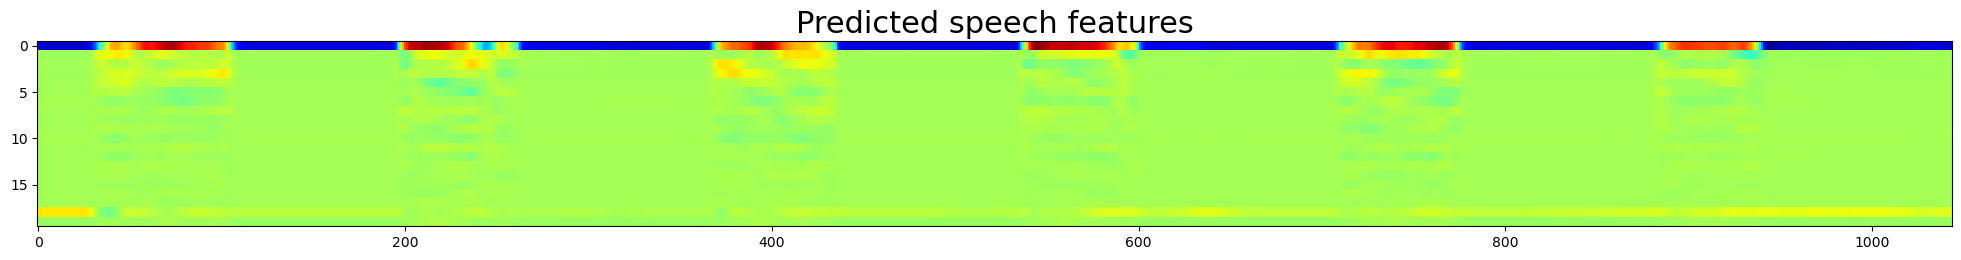

(37584,)


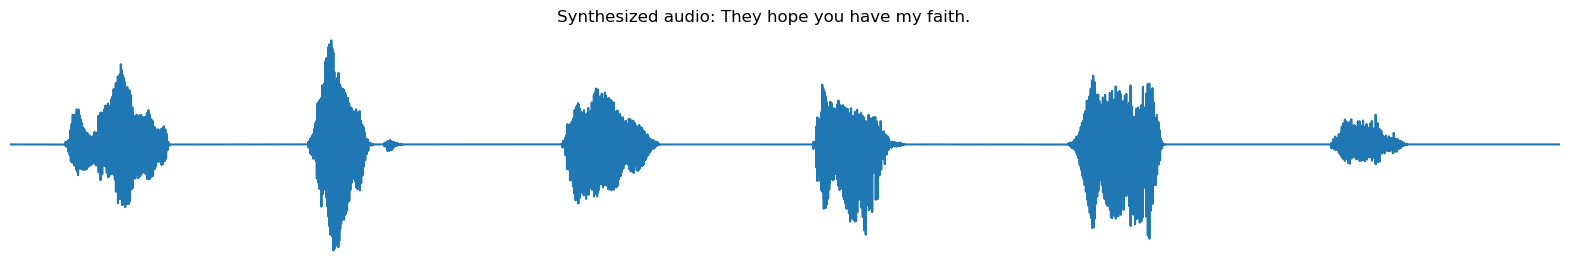

----------------------------
Block 9 Trial: 4 Sentence: I have you clean.                   
Predicted LPCNet speech features shape:  (810, 20)


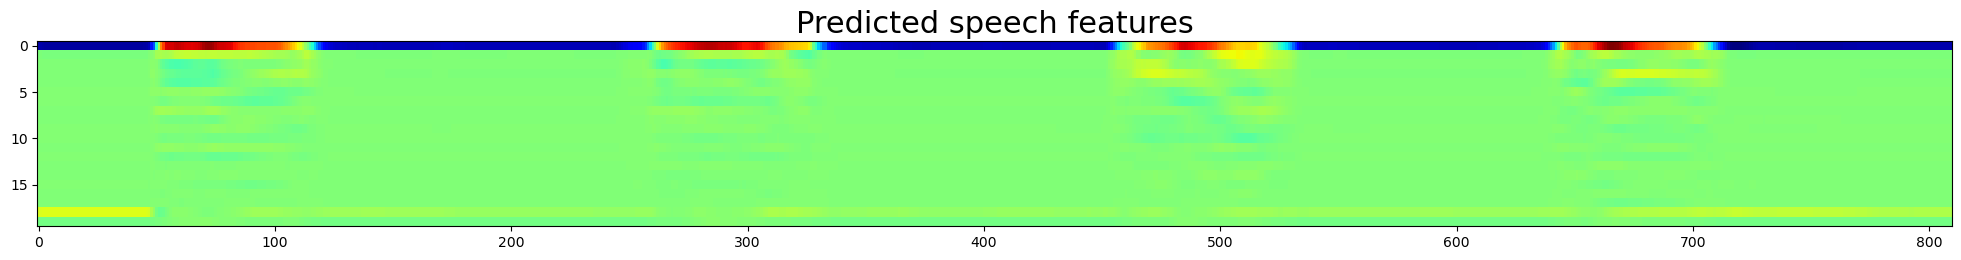

(29160,)


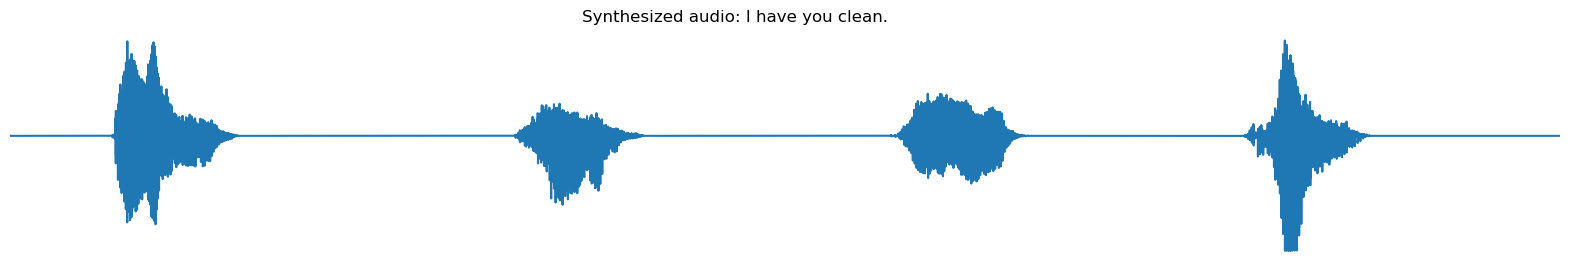

----------------------------


In [ ]:
# ##################################################################################
# Brain-to-voice inference on each tral (offline) - synthesize speech from neural data trials
####################################################################################


for tr in range(3,5) : #n_trials 

    this_sentence       = sentences[tr]   # cue text
    print('Block', block_num, 'Trial:', tr, 'Sentence:', this_sentence)

    # Get neural features for this trial
    neural_features = np.concatenate([spike_pow[tr], thresh_cross[tr]], axis=1)

    # Divide the features into sliding windows of the required squence length
    feat_mat = np.squeeze(get_sliding_windows(neural_features, window_len=SEQ_LEN, step_size=1))

    sess_idx = np.array([SESS_LYR]*feat_mat.shape[0], dtype='int32')
    sess_idx = sess_idx[:, np.newaxis]

    # Perform the trial-wise inference
    prediction = b2voice_model.predict(feat_mat)
    print('Predicted LPCNet speech features shape: ', prediction.shape)
    
    # Scale-up the predicted LPCNet features to their original range (predicted features are in the normalized range)
    prediction  = scale_to_original_range(prediction , min_lpc_feat, max_lpc_feat)

    vz.show_img(np.transpose(prediction), title = ['Predicted speech features'], figsize=[20,3])

    # Reconstruct 36 LPCNet features by computing LPC coefficients from the predicted cepstrum
    features_to_decode = spo.reconstruct_lpcnet_features(prediction.copy())
   
    # Synthesize speech from the predicted LPCNet features
    decoded_file = spo.decode_lpcnet_features_to_wav(features_to_decode, 
                                                    pred_fname+str(tr), 
                                                    lpcnet_path, aud_dat_path)

    time.sleep(1)
   
    # Load the synthesized audio, plot it and play it
    pred_sig, Fs_pred = librosa.load(aud_dat_path+'/'+pred_fname+str(tr)+'.wav', sr=None)  # Load the synthesized audio
    pred_sig = (pred_sig-np.mean(pred_sig))/np.std(pred_sig)  # Normalize for playback in this notebook
    
    fig = plt.figure(figsize=(20,3))
    plt.plot(pred_sig) 
    plt.axis('off')
    plt.title('Synthesized audio: '+this_sentence)
    plt.xlim(0, len(pred_sig))
    plt.show()
    
    display(Audio(data=pred_sig, rate=16000))
    print('----------------------------')
